transform VED 3 from keras to pytorch

In [2]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

In [3]:
# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob


In [4]:
def sampling_to(mean,log_var):
    """
    reparameterization trick in pytorch 
    author: G.Behrens
    """
    
    z_mean=mean
    z_log_var =log_var
    batch= z_mean.size(dim=0) #K.shape(z_mean)[0]
    dim=z_mean.size(dim=1)
    eps=to.normal(mean=0.0,std=1.0,size=(batch,dim))
    sampling_prob=z_mean+to.exp(0.5*z_log_var)*eps
    return sampling_prob

In [5]:
# define hyperparameter  

original_dim_input=109  # CBRAIN input node size

original_dim_output=int(113) # CBRAIN output node size 


# network parameters
latent_dim=9
intermediate_dim = 426   
batch_size = 8627    
kl_weight=0.0001120174143727158
lr_init=0.0006519900493712124
act='elu'

input_shape = (original_dim_input,)
decoder_input_shape=(latent_dim,)
out_shape=(original_dim_output,)

In [6]:
# build VED 3 in keras 

input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation=act)(input_lay)
x_1 =Dense(intermediate_dim, activation=act)(x_0)
x_2 =Dense(intermediate_dim/2, activation=act)(x_1)
x_3 =Dense(intermediate_dim/4, activation=act)(x_2)
x_4 =Dense(intermediate_dim/8, activation=act)(x_3)
x_5 =Dense(intermediate_dim/16, activation=act)(x_4)
z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_lay, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
    
input_decoder=Input(shape=decoder_input_shape, name='decoder_input')
x_0 =Dense(intermediate_dim/16, activation=act)(input_decoder)
x_1 =Dense(intermediate_dim/8, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/2, activation=act)(x_2)
x_4 =Dense(intermediate_dim, activation=act)(x_3)
x_5 =Dense(intermediate_dim, activation=act)(x_4)


outputs_1= Dense(original_dim_output,activation=act)(x_5)
outputs_A = Dense(104,activation='linear')(outputs_1)
outputs_B = Dense(9,activation='relu')(outputs_1)
outputs= Concatenate()([outputs_A,outputs_B])
 
    
# instantiate encoder model
decoder = Model(input_decoder, outputs, name='decoder')
decoder.summary()
decoder_outputs=decoder(encoder(input_lay)[2])
VED_3=Model(input_lay,decoder_outputs, name='VED')
VED_3.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 109)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 426)          46860       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 426)          181902      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 213)          90951       ['dense_1[0][0]']                
                                                                                            

2022-11-02 09:46:35.400689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# load weights into keras VED 3

VED_3.load_weights('real_geography/VEDs/VED_3/VED_3_weights.h5',by_name=True)
VED_3.summary()
VED_3_weights=VED_3.get_weights()



Model: "VED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 encoder (Functional)        [(None, 9),               349958    
                              (None, 9),                         
                              (None, 9)]                         
                                                                 
 decoder (Functional)        (None, 113)               364405    
                                                                 
Total params: 714,363
Trainable params: 714,363
Non-trainable params: 0
_________________________________________________________________


load pytorch 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# build Encoder 3 in pytorch    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.X_1=nn.Linear(109,VED_3_weights[0].shape[1])
        self.X_2=nn.Linear(VED_3_weights[0].shape[1],VED_3_weights[2].shape[1])
        self.X_3=nn.Linear(VED_3_weights[2].shape[1],VED_3_weights[4].shape[1])
        self.X_4=nn.Linear(VED_3_weights[4].shape[1],VED_3_weights[6].shape[1])
        self.X_5=nn.Linear(VED_3_weights[6].shape[1],VED_3_weights[8].shape[1])
        self.X_6=nn.Linear(VED_3_weights[8].shape[1],VED_3_weights[10].shape[1])
        self.z_mean=nn.Linear(VED_3_weights[10].shape[1],VED_3_weights[12].shape[1])
        self.z_log_var=nn.Linear(VED_3_weights[10].shape[1],VED_3_weights[14].shape[1])
        
        

           
    def forward(self,x):
        
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x_1=self.z_mean(x)
        x_2=self.z_log_var(x)
        x=sampling_to(x_1,x_2)
            
        return x

        
        
# build Decoder 3 in pytorch         
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.X_1=nn.Linear(VED_3_weights[14].shape[1],VED_3_weights[16].shape[1])
        self.X_2=nn.Linear(VED_3_weights[16].shape[1],VED_3_weights[18].shape[1])
        self.X_3=nn.Linear(VED_3_weights[18].shape[1],VED_3_weights[20].shape[1])
        self.X_4=nn.Linear(VED_3_weights[20].shape[1],VED_3_weights[22].shape[1])
        self.X_5=nn.Linear(VED_3_weights[22].shape[1],VED_3_weights[24].shape[1])
        self.X_6=nn.Linear(VED_3_weights[24].shape[1],VED_3_weights[26].shape[1])
        self.X_7=nn.Linear(VED_3_weights[26].shape[1],VED_3_weights[28].shape[1])
        self.X_8=nn.Linear(VED_3_weights[28].shape[1],VED_3_weights[30].shape[1])
        self.X_9=nn.Linear(VED_3_weights[28].shape[1],VED_3_weights[32].shape[1])


    def forward(self,x):
        x=F.elu(self.X_1(x))
        x=F.elu(self.X_2(x))
        x=F.elu(self.X_3(x))
        x=F.elu(self.X_4(x))
        x=F.elu(self.X_5(x))
        x=F.elu(self.X_6(x))
        x=F.elu(self.X_7(x))

        x_1=self.X_8(x)
        x_2=F.relu(self.X_9(x))
        x=to.cat([x_1,x_2],1)

            
        return x

        
        
      
    
        



        


In [10]:
# initialized Encoder, Decoder 
Encoder_3=Encoder()
Decoder_3=Decoder()

print(Encoder_3)
print(Decoder_3)



Encoder(
  (X_1): Linear(in_features=109, out_features=426, bias=True)
  (X_2): Linear(in_features=426, out_features=426, bias=True)
  (X_3): Linear(in_features=426, out_features=213, bias=True)
  (X_4): Linear(in_features=213, out_features=106, bias=True)
  (X_5): Linear(in_features=106, out_features=53, bias=True)
  (X_6): Linear(in_features=53, out_features=26, bias=True)
  (z_mean): Linear(in_features=26, out_features=9, bias=True)
  (z_log_var): Linear(in_features=26, out_features=9, bias=True)
)
Decoder(
  (X_1): Linear(in_features=9, out_features=26, bias=True)
  (X_2): Linear(in_features=26, out_features=53, bias=True)
  (X_3): Linear(in_features=53, out_features=106, bias=True)
  (X_4): Linear(in_features=106, out_features=213, bias=True)
  (X_5): Linear(in_features=213, out_features=426, bias=True)
  (X_6): Linear(in_features=426, out_features=426, bias=True)
  (X_7): Linear(in_features=426, out_features=113, bias=True)
  (X_8): Linear(in_features=113, out_features=104, bias=

In [11]:
#load keras weights into pytorch Encoder 
Encoder_3.X_1.weight.data=to.from_numpy(np.transpose(VED_3_weights[0]))
Encoder_3.X_1.bias.data=to.from_numpy(np.transpose(VED_3_weights[1]))
Encoder_3.X_2.weight.data=to.from_numpy(np.transpose(VED_3_weights[2]))
Encoder_3.X_2.bias.data=to.from_numpy(np.transpose(VED_3_weights[3]))
Encoder_3.X_3.weight.data=to.from_numpy(np.transpose(VED_3_weights[4]))
Encoder_3.X_3.bias.data=to.from_numpy(np.transpose(VED_3_weights[5]))
Encoder_3.X_4.weight.data=to.from_numpy(np.transpose(VED_3_weights[6]))
Encoder_3.X_4.bias.data=to.from_numpy(np.transpose(VED_3_weights[7]))
Encoder_3.X_5.weight.data=to.from_numpy(np.transpose(VED_3_weights[8]))
Encoder_3.X_5.bias.data=to.from_numpy(np.transpose(VED_3_weights[9]))
Encoder_3.X_6.weight.data=to.from_numpy(np.transpose(VED_3_weights[10]))
Encoder_3.X_6.bias.data=to.from_numpy(np.transpose(VED_3_weights[11]))
Encoder_3.z_mean.weight.data=to.from_numpy(np.transpose(VED_3_weights[12]))
Encoder_3.z_mean.bias.data=to.from_numpy(np.transpose(VED_3_weights[13]))
Encoder_3.z_log_var.weight.data=to.from_numpy(np.transpose(VED_3_weights[14]))
Encoder_3.z_log_var.bias.data=to.from_numpy(np.transpose(VED_3_weights[15]))



In [12]:
#load keras weights into pytorch Decoder 

Decoder_3.X_1.weight.data=to.from_numpy(np.transpose(VED_3_weights[16]))
Decoder_3.X_1.bias.data=to.from_numpy(np.transpose(VED_3_weights[17]))
Decoder_3.X_2.weight.data=to.from_numpy(np.transpose(VED_3_weights[18]))
Decoder_3.X_2.bias.data=to.from_numpy(np.transpose(VED_3_weights[19]))
Decoder_3.X_3.weight.data=to.from_numpy(np.transpose(VED_3_weights[20]))
Decoder_3.X_3.bias.data=to.from_numpy(np.transpose(VED_3_weights[21]))
Decoder_3.X_4.weight.data=to.from_numpy(np.transpose(VED_3_weights[22]))
Decoder_3.X_4.bias.data=to.from_numpy(np.transpose(VED_3_weights[23]))
Decoder_3.X_5.weight.data=to.from_numpy(np.transpose(VED_3_weights[24]))
Decoder_3.X_5.bias.data=to.from_numpy(np.transpose(VED_3_weights[25]))
Decoder_3.X_6.weight.data=to.from_numpy(np.transpose(VED_3_weights[26]))
Decoder_3.X_6.bias.data=to.from_numpy(np.transpose(VED_3_weights[27]))
Decoder_3.X_7.weight.data=to.from_numpy(np.transpose(VED_3_weights[28]))
Decoder_3.X_7.bias.data=to.from_numpy(np.transpose(VED_3_weights[29]))
Decoder_3.X_8.weight.data=to.from_numpy(np.transpose(VED_3_weights[30]))
Decoder_3.X_8.bias.data=to.from_numpy(np.transpose(VED_3_weights[31]))
Decoder_3.X_9.weight.data=to.from_numpy(np.transpose(VED_3_weights[32]))
Decoder_3.X_9.bias.data=to.from_numpy(np.transpose(VED_3_weights[33]))


In [13]:
# define input and output vars 

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the VED training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}





# load vertical axis in pressure coords 

from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [14]:
# predict with keras VED 3
pred_keras= VED_3.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 1ms/step


In [15]:
print(pred_keras.shape)
pred_keras[0]

(13824, 113)


array([ 7.89288634e-11,  8.30606695e-11,  1.32132527e-10,  3.10591552e-11,
       -1.85330282e-06,  2.19114008e-06, -1.22178881e-06, -3.21208972e-07,
        9.62167178e-07,  1.85898148e-06, -3.79782796e-06, -2.07564226e-05,
       -3.12320481e-05, -1.23692676e-04, -4.22857702e-05,  2.28043646e-05,
        2.24765390e-04,  5.65194525e-04, -1.38359144e-04, -2.18869559e-03,
       -2.02590600e-03, -2.03333329e-04, -1.28652155e-03, -2.42800452e-03,
        3.10201012e-03, -2.75003165e-03,  4.60156947e-02,  3.60256992e-04,
       -3.89016233e-03,  3.34185921e-03,  7.06987828e-03,  7.38785788e-03,
        6.83752075e-03,  3.98314837e-03,  5.79475798e-03,  4.81646415e-03,
        3.21799144e-03,  2.33799312e-03,  1.34764984e-03,  1.30330934e-03,
        9.68426466e-05, -1.43694133e-03, -5.42230159e-03, -1.22356173e-02,
       -1.85006447e-02, -2.02017948e-02, -2.50611641e-02, -2.14491747e-02,
       -2.63375901e-02, -3.28851342e-02, -4.36246619e-02,  4.00905311e-02,
       -1.13895560e-10, -

In [16]:
# predict with pytorch VED 3
pred_pytorch=Decoder_3(Encoder_3(to.from_numpy(val_gen_II[300][0])))
pred_pytorch[0]

tensor([ 6.7061e-11,  7.0457e-11,  1.1190e-10,  2.6026e-11, -1.6070e-06,
         1.2812e-06, -1.1227e-06, -1.4809e-07,  1.5241e-06,  2.8034e-06,
        -1.4438e-06, -1.6288e-05, -3.4579e-05, -1.6222e-04, -2.2467e-04,
        -5.4192e-04, -7.5182e-04, -3.7990e-04,  8.3465e-06, -1.3160e-03,
        -3.4893e-03,  1.2275e-03,  1.6081e-03, -2.3159e-03, -4.2574e-03,
        -1.3656e-02,  3.9382e-02, -4.7137e-03, -7.3871e-03,  9.5081e-04,
         5.0321e-03,  5.6542e-03,  5.4145e-03,  2.6141e-03,  4.9999e-03,
         4.1025e-03,  2.7105e-03,  1.7731e-03,  1.9769e-04, -5.1287e-04,
        -1.4423e-03, -2.1645e-03, -5.6028e-03, -1.2798e-02, -1.9417e-02,
        -2.0112e-02, -2.3117e-02, -2.2450e-02, -2.8611e-02, -3.3667e-02,
        -4.6572e-02,  3.4134e-02, -9.6415e-11, -1.7035e-11,  6.0393e-11,
         4.6425e-11,  7.5933e-11,  1.9261e-11,  4.5306e-11, -1.5508e-10,
         6.1751e-11, -3.5726e-12,  1.5595e-10, -7.1400e-11, -2.9500e-11,
         9.4151e-12,  1.7961e-05, -5.4975e-05, -5.9

In [17]:
pred_pytorch.shape

torch.Size([13824, 113])

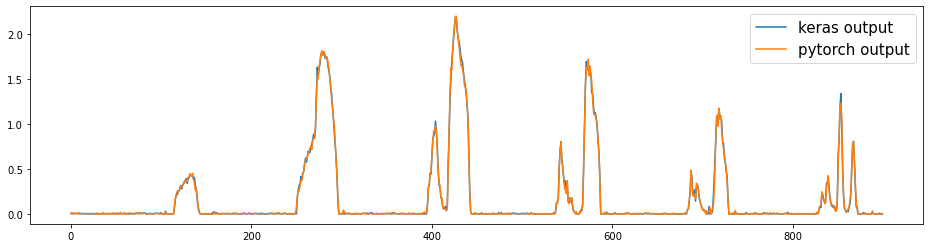

In [18]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

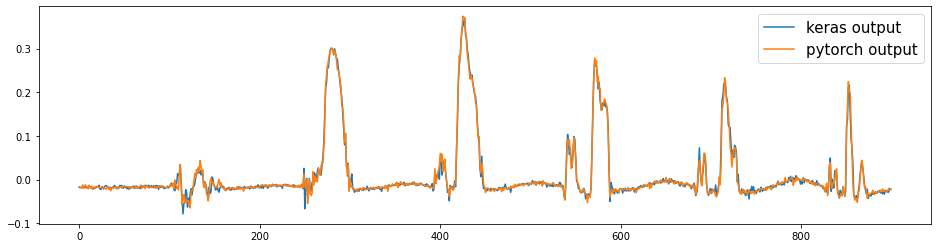

In [19]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,45],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,45],label='pytorch output')
plt.legend(fontsize=15)

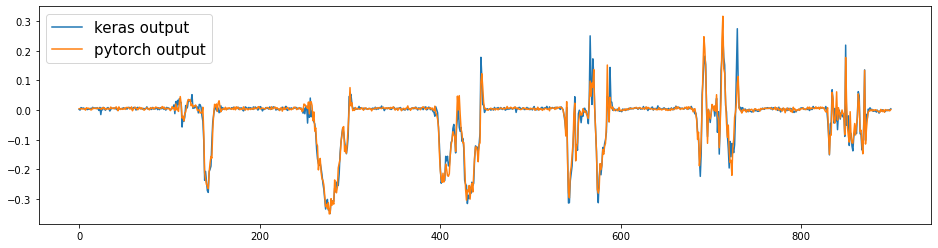

In [20]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,73],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,73],label='pytorch output')
plt.legend(fontsize=15)

In [21]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=1E-3)

In [22]:
a.shape

(13824, 113)

In [23]:
np.where(a==False)[0].size

809943

In [24]:
np.where(a==True)[0].size

752169

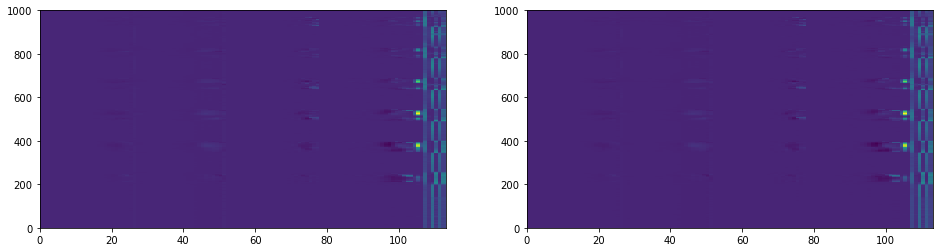

In [25]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])


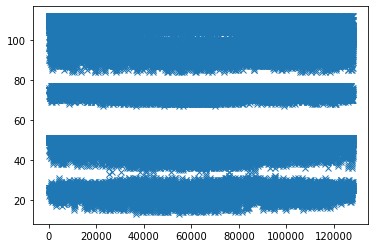

In [26]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-2)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [27]:
#save weights and biases of Encoder 3 and Decoder 3 in pytorch 
to.save(Encoder_3,'real_geography/VEDs/VED_3/VEncoder_3_torch.pt')
to.save(Decoder_3,'real_geography/VEDs/VED_3/VDecoder_3_torch.pt')


In [28]:
# save Encoder 3 
enc_mod = to.jit.trace(Encoder_3, to.from_numpy(val_gen_II[300][0]))
to.jit.save(enc_mod,'real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 124395 / 124416 (100.0%)
Greatest absolute difference: 6.324012517929077 at index (9072, 0) (up to 1e-05 allowed)
Greatest relative difference: 24240.110416666666 at index (6197, 5) (up to 1e-05 allowed)
  _check_trace(


In [29]:
# save Decoder 3

dec_mod = to.jit.trace(Decoder_3, Encoder_3(to.from_numpy(val_gen_II[300][0])))
to.jit.save(dec_mod,'real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad
